# Tumor-specific MSI x Gene associations

Derived from Bailey, Tokheim, Porta-Pardo et al Cell 2018

## Setup

In [1]:
suppressPackageStartupMessages({
    library(BiocOncoTK) # for bindMSI
    library(curatedTCGAData)
})

1/59 packages newly attached/loaded, see sessionInfo() for details.
14/13 packages newly attached/loaded, see sessionInfo() for details.


## Target elements
In this chunk we define the three markers of tumor infiltration and the tumors of interest. 

In [34]:
infilGenes = c(`PD-L1`="CD274", `PD-L2`="PDCD1LG2", CTLA4="CTLA4") #CD8A="CD8A")
tumcodes = c("COAD", "STAD", "UCEC", "BRCA")

The most expensive computation is the creation of a MultiAssayExperiment based on the
tumor codes of interest.  This should be done as infrequently as possible.

In [35]:
if (exists("rna3") & !all(sapply(tumcodes, function(x) length(grep(x, names(experiments(rna3))))>0))) {
     suppressMessages(rna3 <- curatedTCGAData(tumcodes, "RNASeq2GeneNorm", dry.run=FALSE))
    }

We now
acquire the data using `curatedTCGAData`.  The `combs` structure lays out the combinations of
tumor and gene required for the graphical survey.

In [36]:
combs = expand.grid(tumcode=tumcodes, ali=names(infilGenes),
    stringsAsFactors=FALSE)
combs$sym = infilGenes[combs$ali]


This function binds MSI data to samples and produces a data.frame relating
MSI and expression for a selected gene.  The input is assumed to be a MultiAssayExperiment
and the expression data is limited to the data on the tumor given by `tumcode`.

In [37]:
exprByMSI = function(mae, tumcode, genesym, alias) {
 nn = names(experiments(mae))
 wh = grep(tumcode, nn) 
 stopifnot(length(wh)==1)
 curse = experiments(mae)[[wh]]
 colnames(curse) = substr(colnames(curse),1,12)
 curex = bindMSI(curse)
 data.frame(patient_barcode = colnames(curex),
  acronym=tumcode,
  symbol = genesym,
  alias = genesym,
  log2ex = log2(as.numeric(SummarizedExperiment::assay(
     curex[genesym,]))+1),
  msicode = ifelse(curex$msiTest >= 4, ">=4", "<4"))
}


Now we use the `combs` structure to develop the data reduction and produce the plot.

0/0 packages newly attached/loaded, see sessionInfo() for details.


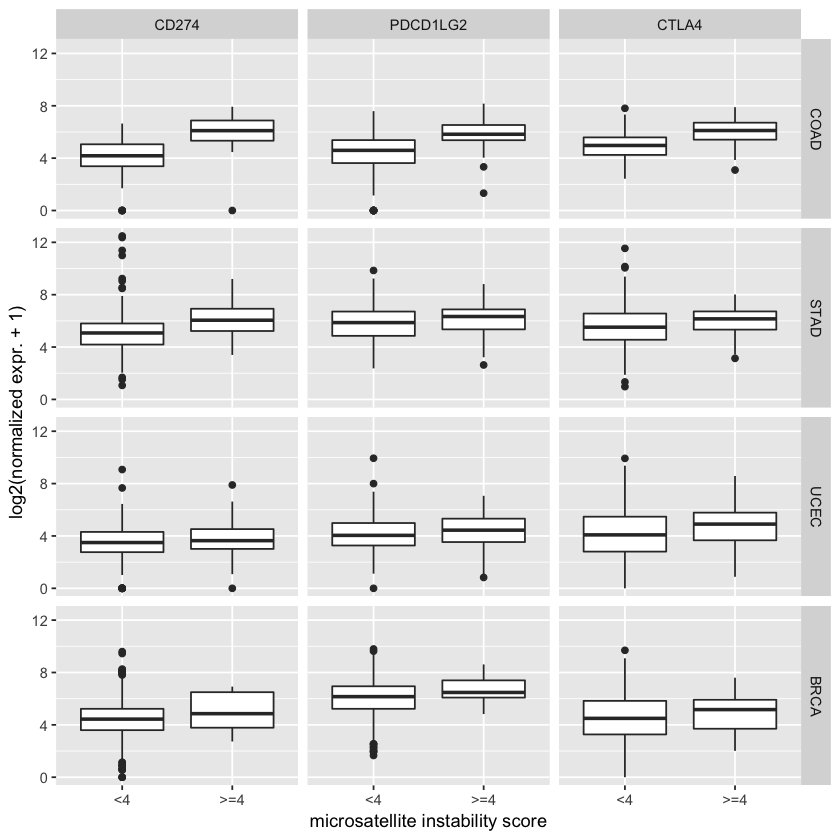

In [38]:
 allshow = lapply(1:nrow(combs), function(x) exprByMSI(rna3, combs$tumcode[x],
    combs$sym[x], combs$ali[x]))

 rr = do.call(rbind, allshow)

 library(ggplot2)
 ggplot(rr,
    aes(msicode, log2ex)) + geom_boxplot() +
    facet_grid(acronym~alias) +
    ylab("log2(normalized expr. + 1)") +
    xlab("microsatellite instability score")